In [1]:
import ast
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

DATA_PATH    = '../data/'
SCRIPTS_PATH = '../scripts/'

sys.path.append(SCRIPTS_PATH)

# функции по визуализации данных 
from features import count_features_per_genre
from features import avg_feature_per_genre
from features import genre_free_percent_per_genre
from features import sum_feature_per_genre
from features import age_group_distribution
from features import free_paid_per_genre
from features import genre_group_distribution
from features import count_collections_per_genre
from features import avg_collections_per_genre
from features import sum_collections_per_genre

from features import get_top5_for_genre

from features import t_test_free_score
from features import barplot_free_score
from features import chi2_stat_collection_score
from features import heatmap_collection_score

# установка глобальных параметров
pd.set_option('display.max_columns', 60)
plt.rcParams['figure.figsize'] = (12, 4)

# Знакомство с данными

### **Apple**

Датасет **AppStoreApps** представляет собой характеристики приложений полученных из Apple AppStore.

Структура:
* **title** - Название приложения
* **genres** - Жанры
* **primaryGenre** - Основной жанр
* **contentRating** - Рейтинг контента
* **languages** - Языки
* **size** - Размер приложения
* **requiredOsVersion** - Требуемая версия ОС
* **released** - Дата релиза
* **updated** - Дата обновления
* **version** - Версия приложения
* **price** - Цена
* **currency** - Валюта
* **free** - Бесплатное или нет
* **score** - Оценка
* **reviews** - Число отзывов
* **currentVersionScore** - Оценка текущей версии
* **currentVersionReviews** - Число отзывов на текущую версию
* **collection** - Коллекция
* **lang** - Язык интерфейса

**Коллекции** представлены следующими группами:
* **NEW**  
    >Описание: Новые приложения в App Store, включающие как бесплатные, так и платные.  
    >Пример: Новые приложения, которые только что стали доступны, независимо от их цены.  

* **NEW_FREE**  
    >Описание: Приложения, недавно добавленные в App Store и доступные бесплатно.  
    >Пример: Приложения, только что выпущенные и еще не набравшие значительного количества отзывов или оценок.

* **NEW_PAID**  
    >Описание: Платные приложения, недавно добавленные в App Store.  
    >Пример: Новые платные приложения, которые только что вышли на рынок.  

* **TOP_FREE**
    >Описание: Самые популярные бесплатные приложения в App Store.  
    >Пример: Приложения, которые имеют большое количество загрузок и активных пользователей, но не требуют оплаты для скачивания.  

* **TOP_GROSSING**  
    >Описание: Приложения, приносящие наибольший доход в App Store.  
    >Пример: Приложения с высоким уровнем покупок внутри приложения или подписок, приносящие значительный доход.  

* **TOP_PAID**  
    >Описание: Самые популярные платные приложения в App Store.  
    >Пример: Платные приложения, которые имеют большое количество загрузок и высокие оценки.

### **Google**

Датасет **GooglePlayApps** представляет собой характеристики приложений полученных из Google Play.

Структура:
* **title** - Название приложения
* **installs** - Количество установок
* **score** - Оценка
* **scoreText** - Текстовая оценка
* **ratings** - Число рейтингов
* **reviews** - Число отзывов
* **price** - Цена
* **free** - Бесплатное или нет
* **currency** - Валюта
* **offersIAP** - Наличие встроенных покупок
* **adSupported** - Поддержка рекламы
* **containsAds** - Наличие рекламы
* **released** - Дата релиза
* **updated** - Дата обновления
* **version** - Версия приложения
* **developer** - Разработчик
* **summary** - Описание
* **histogram** - Гистограмма оценок
* **available** - Доступность
* **collection** - Коллекция
* **lang** - Язык интерфейса

# Подготовка данных

In [2]:
AppStoreApps    = pd.read_csv(DATA_PATH + 'AppStoreApps.csv', low_memory=False)
GooglePlayApps  = pd.read_csv(DATA_PATH + 'GooglePlayApps.csv')

# GooglePlayApps  = GooglePlayApps.iloc[:,1:]
AppStoreApps.shape, GooglePlayApps.shape

((19794, 19), (12040, 35))

In [3]:
AppStoreApps.head(3)

,title,genres,primaryGenre,contentRating,languages,size,requiredOsVersion,released,updated,version,price,currency,free,score,reviews,currentVersionScore,currentVersionReviews,collection,lang
0,Perkss Customer,"['Food & Drink', 'Shopping']",Food & Drink,4+,"['AR', 'EN']",112585728,11.0,2024-03-25T07:00:00Z,2024-07-28T10:20:17Z,1.0.3,0.0,USD,True,0.0,0,0.0,0,NEW_FREE_IOS,en
1,Worthy Resume,"['Business', 'Utilities']",Business,4+,['EN'],49355776,11.0,2019-10-08T07:00:00Z,2024-07-28T10:20:17Z,1.0.1,0.0,USD,True,1.0,2,1.0,2,NEW_FREE_IOS,en
2,Trend IT Contigo,['Utilities'],Utilities,4+,"['CA', 'EN', 'DE', 'ES']",155981824,14.0,2024-06-23T07:00:00Z,2024-07-28T10:17:22Z,1.9.0,0.0,USD,True,0.0,0,0.0,0,NEW_FREE_IOS,en


In [4]:
GooglePlayApps.head(3)

,Unnamed: 0,title,installs,score,scoreText,ratings,reviews,price,free,currency,priceText,available,offersIAP,IAPRange,genre,genreId,categories,contentRating,contentRatingDescription,adSupported,released,updated,version,preregister,earlyAccessEnabled,isAvailableInPlayPass,histogram.1,histogram.2,histogram.3,histogram.4,histogram.5,originalPrice,discountEndDate,collection,lang
0,0,MONOPOLY GO!,"50,000,000+",4.448173,4.4,2364175.0,225426.0,0.0,True,USD,Free,True,True,$0.99 - $199.99 per item,Board,GAME_BOARD,"[{'name': 'Board', 'id': 'GAME_BOARD'}, {'name...",Everyone,Mild Fantasy Violence,False,"Apr 11, 2023",1.721937e+12,1.26.1,False,False,False,191227.0,39931.0,75775.0,268341.0,1788890.0,NaN,NaN,GROSSING,en
1,1,Royal Match,"100,000,000+",4.626536,4.6,6487183.0,72420.0,0.0,True,USD,Free,True,True,$0.99 - $99.99 per item,Puzzle,GAME_PUZZLE,"[{'name': 'Puzzle', 'id': 'GAME_PUZZLE'}, {'na...",Everyone,Mild Fantasy Violence,False,"Feb 25, 2021",1.721403e+12,22799,False,False,False,150196.0,80039.0,337821.0,906156.0,5012954.0,NaN,NaN,GROSSING,en
2,2,Candy Crush Saga,"1,000,000,000+",4.599701,4.6,37749518.0,2086257.0,0.0,True,USD,Free,True,True,$0.99 - $149.99 per item,Casual,GAME_CASUAL,"[{'name': 'Puzzle', 'id': 'GAME_PUZZLE'}, {'na...",Everyone,NaN,True,"Nov 15, 2012",1.721894e+12,1.282.3.1,False,False,False,934653.0,473843.0,1956839.0,6037233.0,28346937.0,NaN,NaN,GROSSING,en


Выполним первоначальные преобразования данных для выполнения анализа.

In [5]:
# преобразование возрастного рейтига к численным значениям
AppStoreApps['contentRating'] = AppStoreApps['contentRating'].apply(lambda x: 4 if x == '4+' in x else x)
AppStoreApps['contentRating'] = AppStoreApps['contentRating'].apply(lambda x: 9 if x == '9+' in x else x)
AppStoreApps['contentRating'] = AppStoreApps['contentRating'].apply(lambda x: 12 if x == '12+' in x else x)
AppStoreApps['contentRating'] = AppStoreApps['contentRating'].apply(lambda x: 17 if x == '17+' in x else x)

# переименование категорий, объединение данных для IOS и IPAD
AppStoreApps['collection'] = AppStoreApps['collection'].apply(lambda x: 'NEW' if x == 'NEW_IOS' in x else x)
AppStoreApps['collection'] = AppStoreApps['collection'].apply(lambda x: 'NEW_FREE' if x == 'NEW_FREE_IOS' in x else x)
AppStoreApps['collection'] = AppStoreApps['collection'].apply(lambda x: 'NEW_PAID' if x == 'NEW_PAID_IOS' in x else x)
AppStoreApps['collection'] = AppStoreApps['collection'].apply(lambda x: 'TOP_FREE' if x == 'TOP_FREE_IOS' or 'TOP_FREE_IPAD' in x else x)
AppStoreApps['collection'] = AppStoreApps['collection'].apply(lambda x: 'TOP_GROSSING' if x == 'TOP_GROSSING_IOS' or 'TOP_GROSSING_IPAD' in x else x)
AppStoreApps['collection'] = AppStoreApps['collection'].apply(lambda x: 'TOP_PAID' if x == 'TOP_PAID_IOS' or 'TOP_PAID_IPAD' in x else x)

# преобразование строковой записи в списки
AppStoreApps['genres']     = AppStoreApps['genres'].apply(ast.literal_eval)
AppStoreApps['languages']  = AppStoreApps['languages'].apply(ast.literal_eval)

# оставим только игры
AppStoreApps = AppStoreApps[AppStoreApps['primaryGenre'] == 'Games']

# приведение размера к Мб
AppStoreApps['size']  = round((AppStoreApps['size'] / 1000) / 1000).astype(int)

# округление оценок до десятых
AppStoreApps['score'] = AppStoreApps['score'].round(1)

# оставим только игры для русскоязычного сегмента
AppStoreApps = AppStoreApps[AppStoreApps['lang'] == 'ru']

In [6]:
# список жанров
genres_list = ['Action', 'Adventure', 'Casino', 'Casual',
               'Family', 'Puzzle', 'Racing', 'Role Playing',
               'Simulation', 'Sports', 'Strategy']

Так как у игры может быть более одного жанра, извлечем данные и признака "genre" и создадим для каждого жанра свой признак.

In [7]:
# создание признаков для каждого жанра в целевом списке, инициализация их пустыми строками
for genre in genres_list:
    AppStoreApps[genre] = None

# заполнение признаков в зависимости от наличия жанров в каждом списке
for index, row in AppStoreApps.iterrows():
    for genre in row['genres']:
        if genre in genres_list:
            AppStoreApps.at[index, genre] = genre

In [8]:
# удалим неиспользуемые признаки
AppStoreApps = AppStoreApps.drop(['genres', 'primaryGenre', 'languages', 'requiredOsVersion', 
                                  'released', 'updated', 'version', 'currentVersionScore', 
                                  'currentVersionReviews'], axis=1)

AppStoreApps = AppStoreApps.drop_duplicates()

AppStoreApps.head(3)

,title,contentRating,size,price,currency,free,score,reviews,collection,lang,Action,Adventure,Casino,Casual,Family,Puzzle,Racing,Role Playing,Simulation,Sports,Strategy
112,Badminton Frenzy,12,220,0.0,USD,True,0.0,0,NEW_FREE,ru,Action,None,None,Casual,None,None,None,None,None,None,None
119,Bingo Linkup,4,14,0.0,USD,True,0.0,0,NEW_FREE,ru,None,None,None,None,None,None,None,None,None,None,None
120,Bizarre Spa,12,201,0.0,USD,True,0.0,0,NEW_FREE,ru,None,None,None,Casual,None,None,None,None,Simulation,None,None


# Визуализация

Для анализа отобраны игры только для рускоязычного сегмента рынка.

## Apple

### Тренды в жанрах

Оценим популярность жанров, посмотрим на количество игр в каждом из жанров

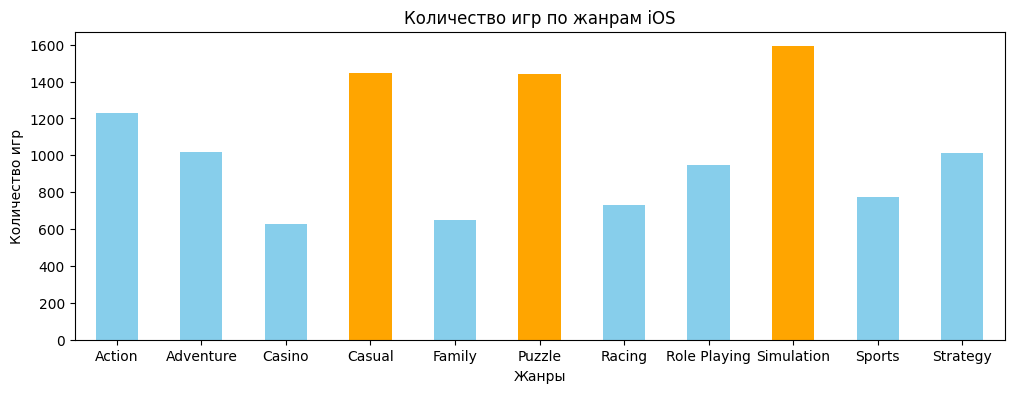

In [9]:
count_features_per_genre(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    title       = 'Количество игр по жанрам iOS', 
    xlabel      = 'Жанры', 
    ylabel      = 'Количество игр'
)

Судя по количеству выпускаемых игр, наиболее популярными жанрами являются *Casual*, *Puzzle*, *Simulation*.  

Это обусловленно тем, что жанры **Casual** и **Puzzle** не требуют больших знаний механик игры и очень легки в освоении. К тому же это "ситуационные" игры, в которые можно быстро поиграть, когда выдалась буквально пара минут свободного времени. 

Они не требуют большого вовлечения, изучения и запоминания событий в игре. К ним можно вернуться и через пару минут и через несколько месяцев, вспоминать на чем остановился в прошлый раз нет необходимости.

В жанре **Simulation** представлены как спортивные симуляторы, так и всевозможные "симуляторы жизни", в которых ты развиваешь, улучшаешь и следишь за развитием объекта игры.

**Первоначальное предложение заказчика - Разработать игру "Ситибилдер" (Simulation) с миниигрой "3 в Ряд" (Casual, Puzzle), вполне логично исходя из тренда.**

Примеры популярных игр из выбранных жанров

In [10]:
get_top5_for_genre(AppStoreApps, 'Casual')

,title,Casual,score,price,contentRating
14116,Bounce Ball Game,Casual,5.0,0.99,4
11476,iFruitBomb - The Fruit Machine Simulator,Casual,5.0,0.99,17
3355,Which Dress? Left or Right,Casual,5.0,0.00,4
11050,Zen Puzzle Blocks,Casual,5.0,0.29,4
18958,Barcode Knight,Casual,5.0,0.99,9


In [11]:
get_top5_for_genre(AppStoreApps, 'Puzzle')

,title,Puzzle,score,price,contentRating
9841,Прятки Слов,Puzzle,5.0,0.00,4
11050,Zen Puzzle Blocks,Puzzle,5.0,0.29,4
11165,Ghost In The Mirror,Puzzle,5.0,3.99,12
3344,Find Differences Search & Spot,Puzzle,5.0,0.00,4
19137,Classic Columns,Puzzle,5.0,0.99,4


In [12]:
get_top5_for_genre(AppStoreApps, 'Simulation')

,title,Simulation,score,price,contentRating
11365,Choice of Life Middle Ages 2,Simulation,5.0,1.99,17
11037,Другая жизнь II,Simulation,5.0,0.99,4
17225,Choice of Life Middle Ages 2,Simulation,5.0,0.99,17
19471,Townopolis,Simulation,5.0,3.99,4
11192,Merry Cook: Elektronika IM-04,Simulation,5.0,0.99,4


**Проверим популярность жанров в разрезе "коллекций", доступных в AppStore.**

* **NEW** - Новые приложения, включающие как бесплатные, так и платные.
* **NEW_FREE** - Недавно добавленные и доступные бесплатно.
* **NEW_PAID** - Недавно добавленные, платные приложения.
* **TOP_FREE** - Самые популярные бесплатные приложения.
* **TOP_GROSSING** - Приложения, приносящие наибольший доход.
* **TOP_PAID** - Самые популярные платные приложения.

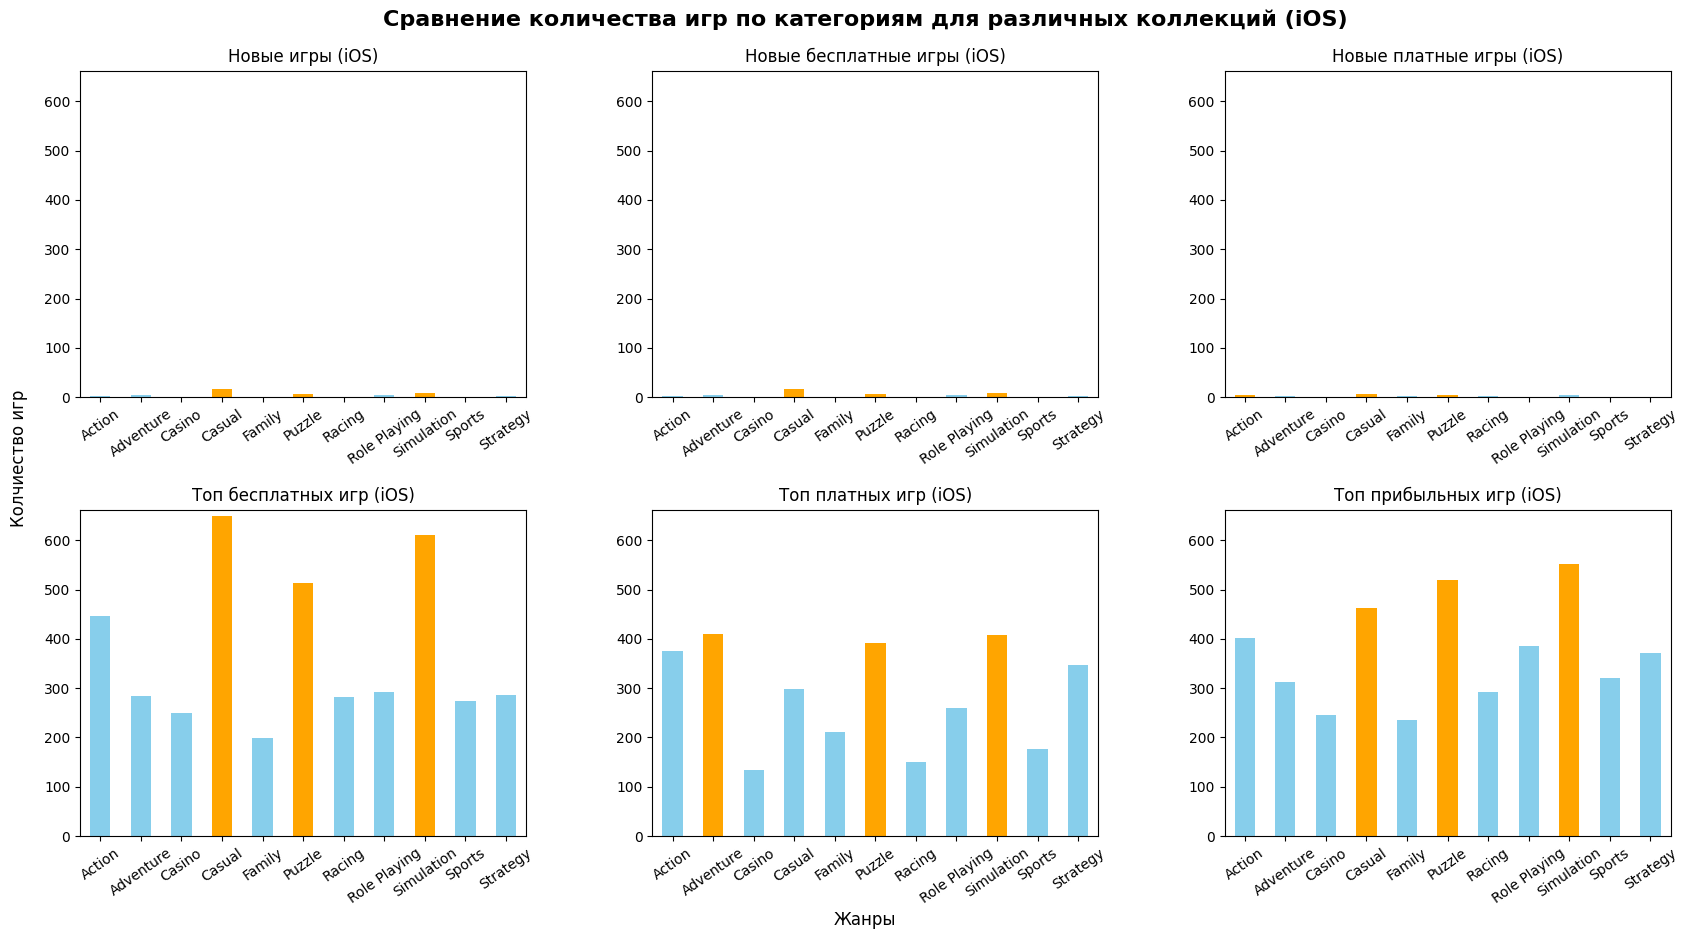

In [13]:
count_collections_per_genre(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    title       = 'Сравнение количества игр по категориям для различных коллекций (iOS)', 
    xlabel      = 'Жанры', 
    ylabel      = 'Колчиество игр'
)

Помимо того, что жанры **Casual** и **Puzzle** наиболее популярны рседи бесплатных игр, они ещё и наиболее прибыльные с точки зрения внутреигровых покупок (поскольку большинство из них распространяется бесплатно)

**Исходя из данных, можно сделать предворительный вывод, что следует разрабатывать игру:**
* **Соответствующую жанрам Casual и Puzzle**
* **Распространяемую бесплатно**
* **Имеющую возможность совершать внутреигровые покупки**

### Средний рейтинг по жанрам

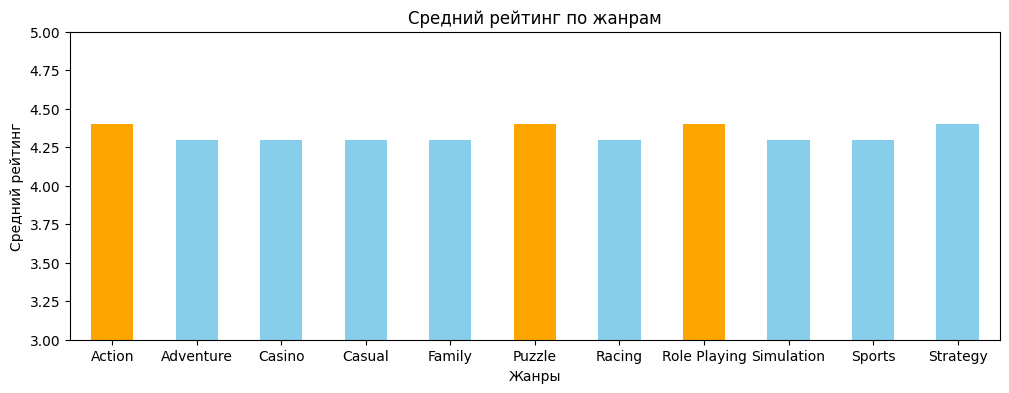

In [14]:
avg_feature_per_genre(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    feature     = 'score', 
    title       = 'Средний рейтинг по жанрам', 
    xlabel      = 'Жанры', 
    ylabel      = 'Средний рейтинг', 
    ylmin       = 3, 
    ylmax       = 5
)

В среднем, исходя из оценок, игроки сколнны ставить более высокие оценки активным играм, находящихся в жанрах Action, Role Playing, Strategy.

Посмотрим, каким жанрам игроки ставят наибольшие оценки исходя из коллекций
* **NEW** - Новые приложения, включающие как бесплатные, так и платные.
* **NEW_FREE** - Недавно добавленные и доступные бесплатно.
* **NEW_PAID** - Недавно добавленные, платные приложения.
* **TOP_FREE** - Самые популярные бесплатные приложения.
* **TOP_GROSSING** - Приложения, приносящие наибольший доход.
* **TOP_PAID** - Самые популярные платные приложения.

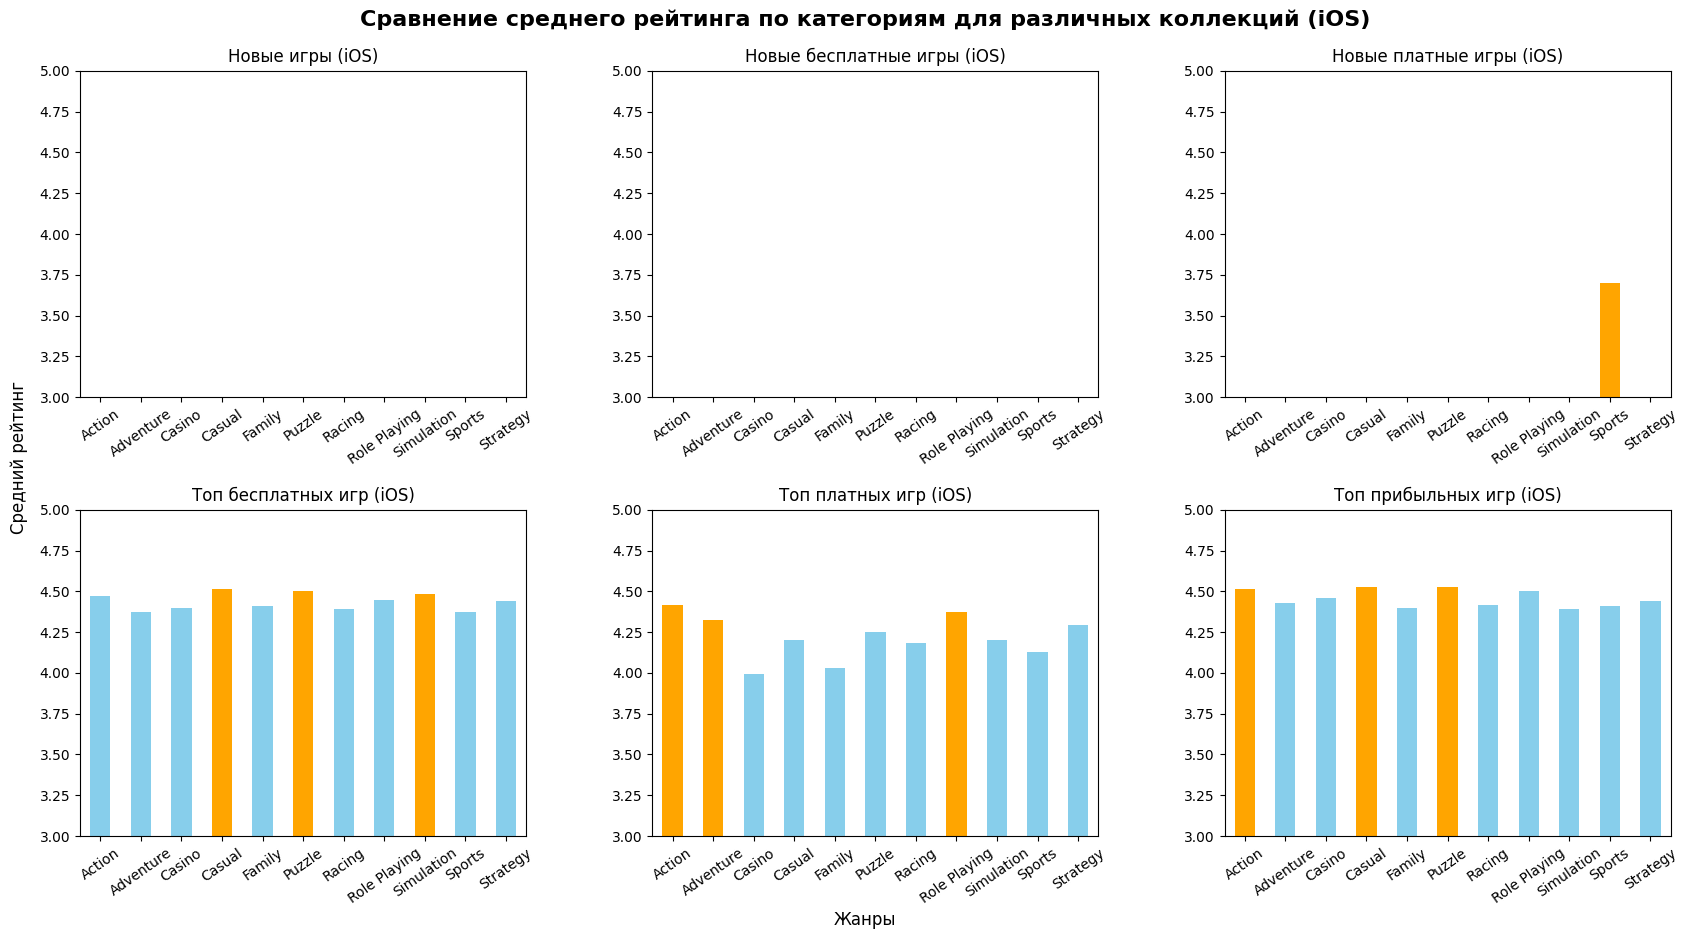

In [15]:
avg_collections_per_genre(
    df          = AppStoreApps,
    genres_list = genres_list,
    feature     = 'score',
    title       = 'Сравнение среднего рейтинга по категориям для различных коллекций (iOS)',
    xlabel      = 'Жанры',
    ylabel      = 'Средний рейтинг',
    ylmin       = 3
)

**Среди бесплатных и наиболее прибыльных жанров, внось присутсвуют Casual (Топ бесплатных) и Puzzle (Топ прибыльных).**

### Количество отзывов по жанрам

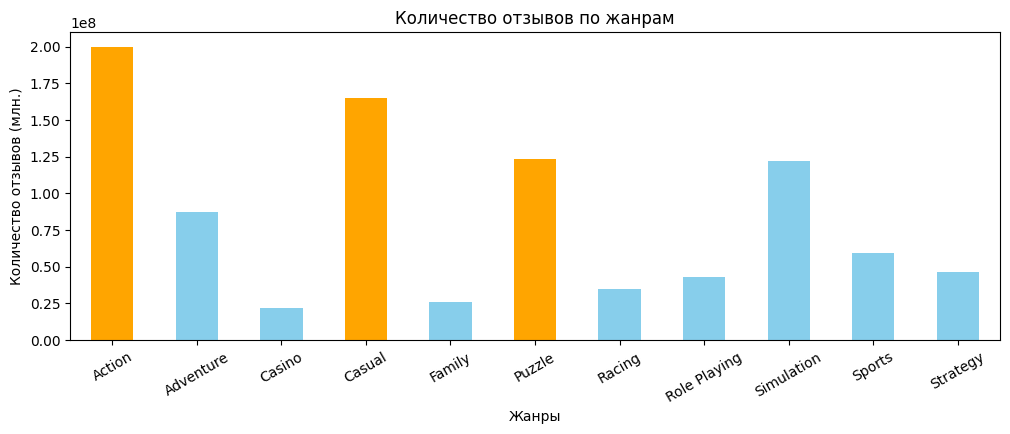

In [16]:
sum_feature_per_genre(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    feature     = 'reviews', 
    title       = 'Количество отзывов по жанрам', 
    xlabel      = 'Жанры', 
    ylabel      = 'Количество отзывов (млн.)'
)

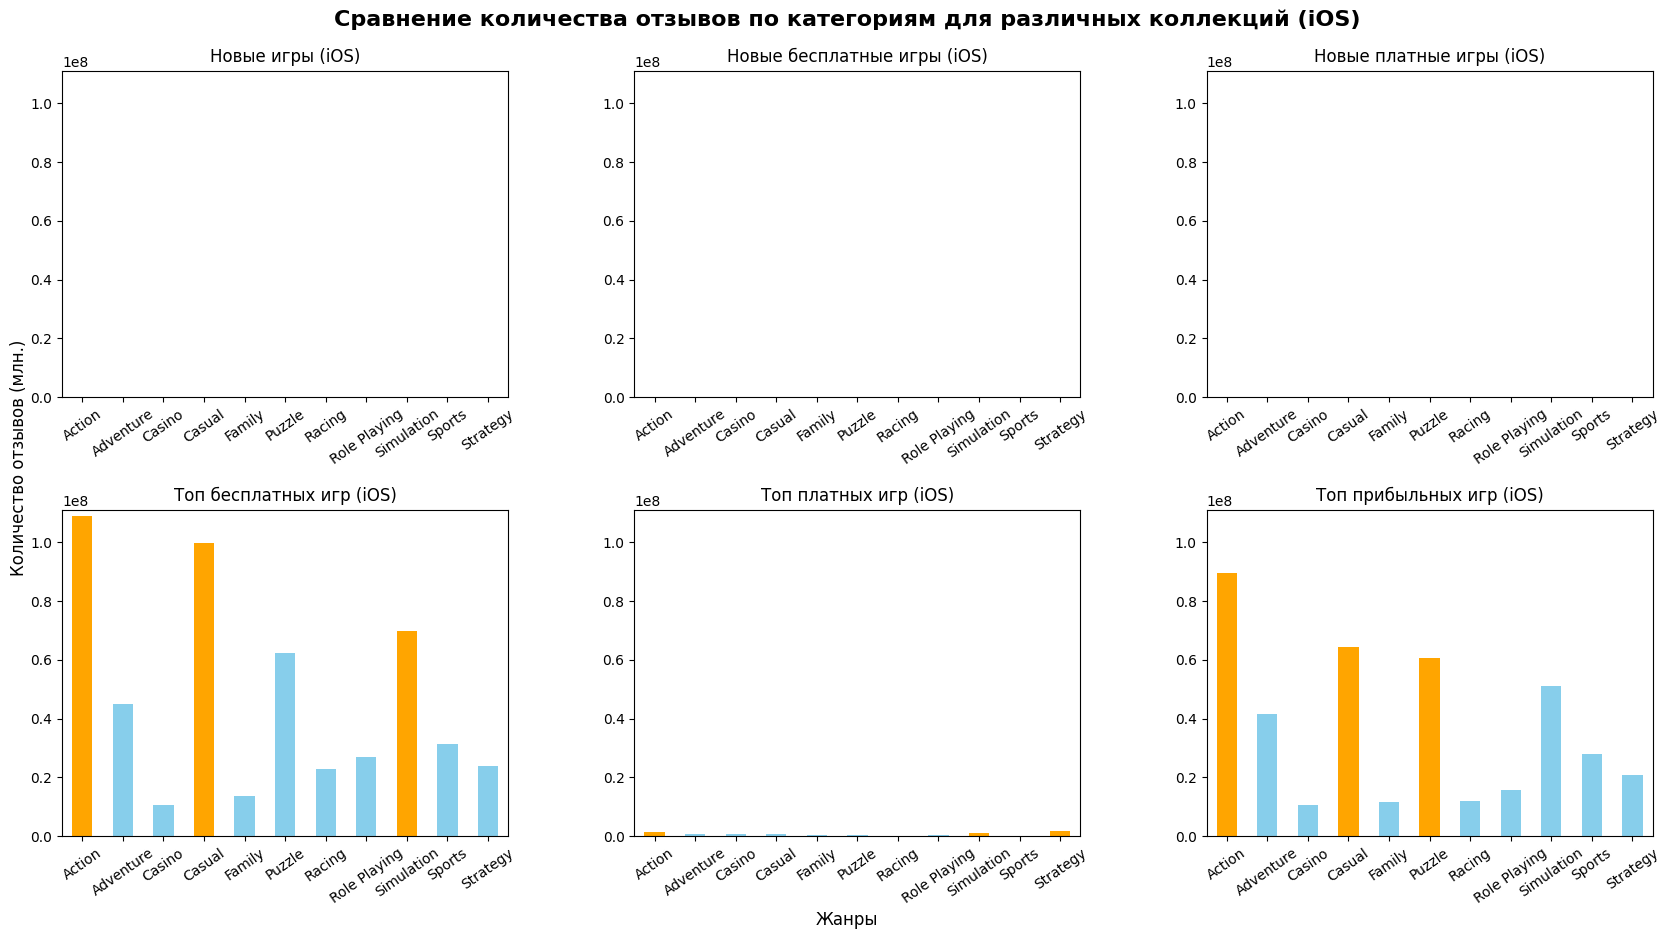

In [17]:
sum_collections_per_genre(
    df          = AppStoreApps,
    genres_list = genres_list,
    feature     = 'reviews',
    title       = 'Сравнение количества отзывов по категориям для различных коллекций (iOS)',
    xlabel      = 'Жанры',
    ylabel      = 'Количество отзывов (млн.)'
)

**Наиболее активно коментируемым жанров является Action, но поскольку разработка игры в этом жанре выходит за временные рамки проекта, следует сосредоточится на жанрах Casual и Puzzle.**

### Средний возрастной рейтинг игр по жанрам

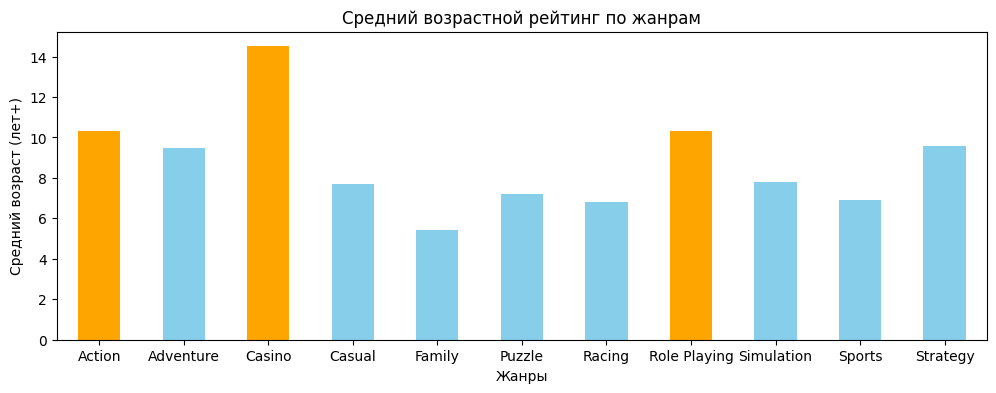

In [18]:
avg_feature_per_genre(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    feature     = 'contentRating', 
    title       = 'Средний возрастной рейтинг по жанрам', 
    xlabel      = 'Жанры', 
    ylabel      = 'Средний возраст (лет+)'
)

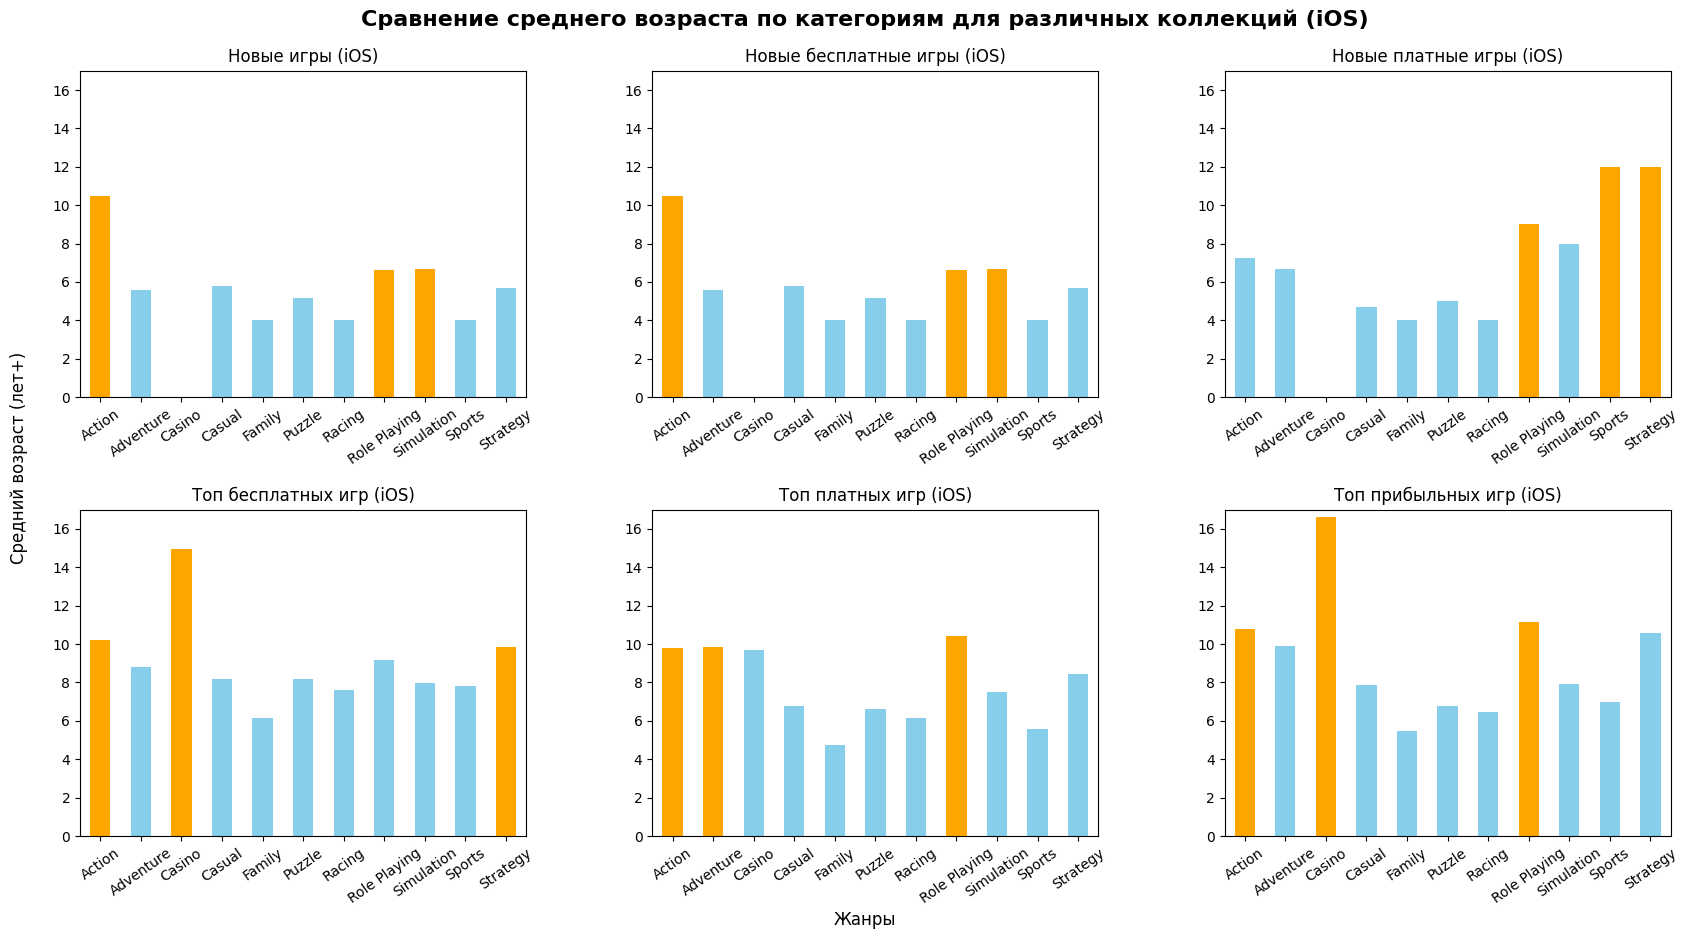

In [19]:
avg_collections_per_genre(
    df          = AppStoreApps,
    genres_list  = genres_list,
    feature     = 'contentRating',
    title       = 'Сравнение среднего возраста по категориям для различных коллекций (iOS)',
    xlabel      = 'Жанры',
    ylabel      = 'Средний возраст (лет+)'
)

**Если брать во внимание жанры Casual, Puzzle, Simulation, то можно сделать вывод о том, что данные жанры популярны начиная с 6+ лет**

**Следовательно, аудитория максимально обширная, начиная от детей, которым нравится ухаживать за животными (они же могут попросить родителей совершить пожертвование в приют), заканчивая взрослыми, которые сознательно могут совершать пожертвования в приют.**

**Видя в игре развитие и улучшение условий для животных, игрок может захотетть принять участие в улучшении условий жизни реальных питомцев.**

### Средний размер игр по жанрам

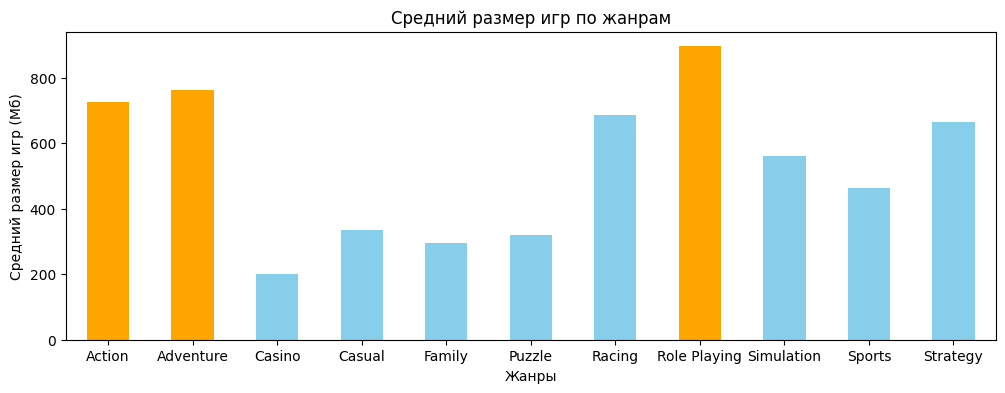

In [20]:
avg_feature_per_genre(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    feature     = 'size', 
    title       = 'Средний размер игр по жанрам', 
    xlabel      = 'Жанры', 
    ylabel      = 'Средний размер игр (Мб)'
)

**Логично, чтбо более активные, продолжительные и сложные в плане сюжета игры имеют больший размер. Исходя из размера текстур, количества уровней и пр.**

**В то же время Casual и Puzzle имеют в среднем, меньший размер приложения, что положительно сказывается в меньшем времени загрузки игры из AppStore и более быстром запуске игры на устройстве.**

### Средняя цена игр по жанрам

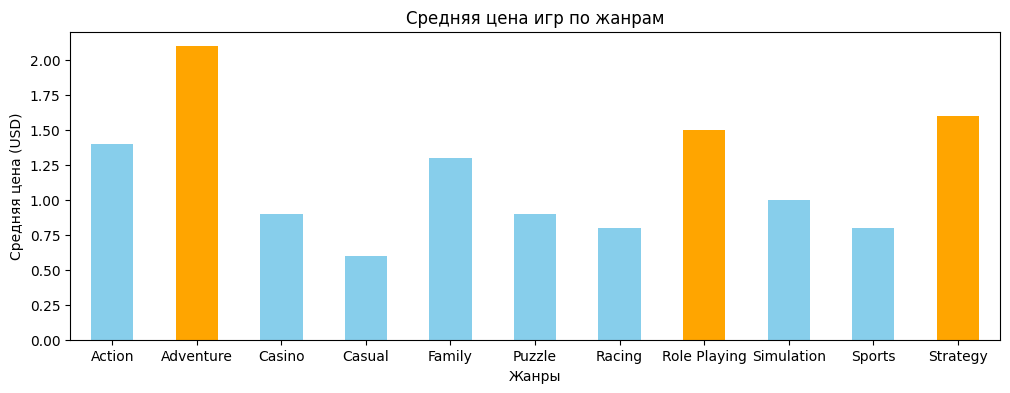

In [21]:
avg_feature_per_genre(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    feature     = 'price', 
    title       = 'Средняя цена игр по жанрам', 
    xlabel      = 'Жанры', 
    ylabel      = 'Средняя цена (USD)'
)

### Бесплатные vs Платные игры

Рассмотрим распределение бесплатных и платных игр по жанрам

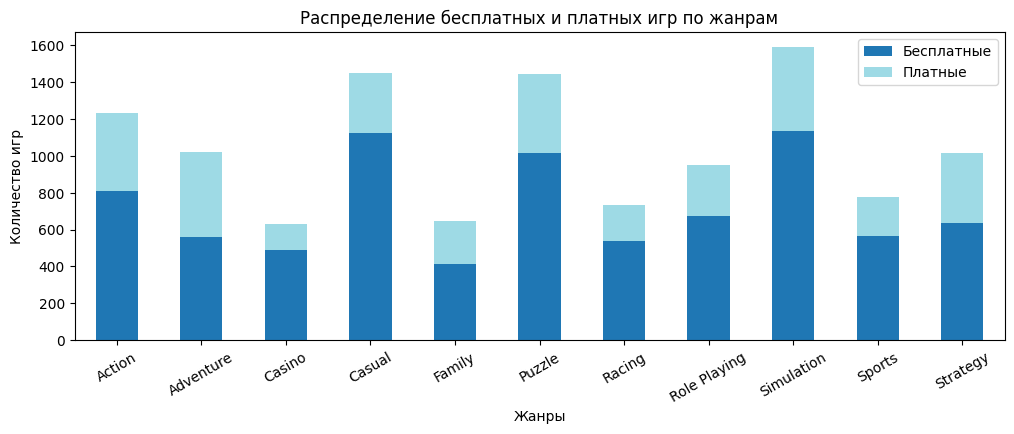

In [22]:
free_paid_per_genre(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    feature     = 'free', 
    title       = 'Распределение бесплатных и платных игр по жанрам', 
    xlabel      = 'Жанры', 
    ylabel      = 'Количество игр'
)

**Интересующие нас жанры - Casual, Puzzle, Simulation, более распространены в бесплатном виде.**

### Процент бесплатных игр по жанрам

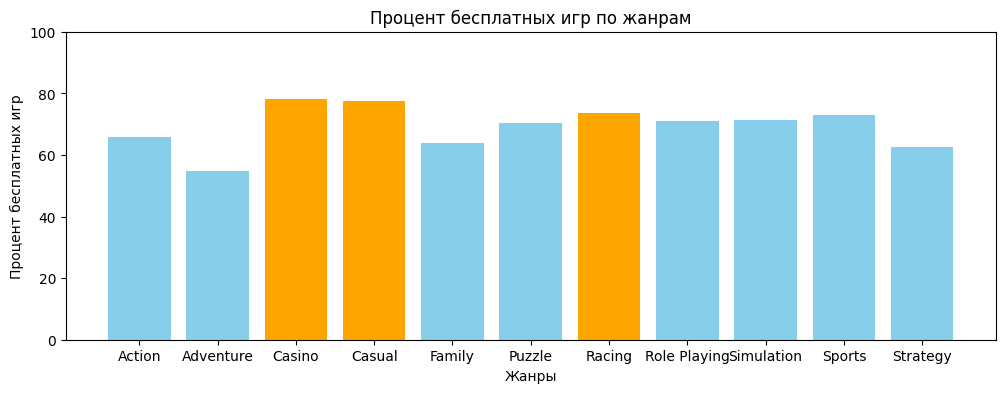

In [23]:
genre_free_percent_per_genre(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    feature     = 'free', 
    title       = 'Процент бесплатных игр по жанрам', 
    xlabel      = 'Жанры', 
    ylabel      = 'Процент бесплатных игр'
)

### Анализ отзывов по возрастным группам

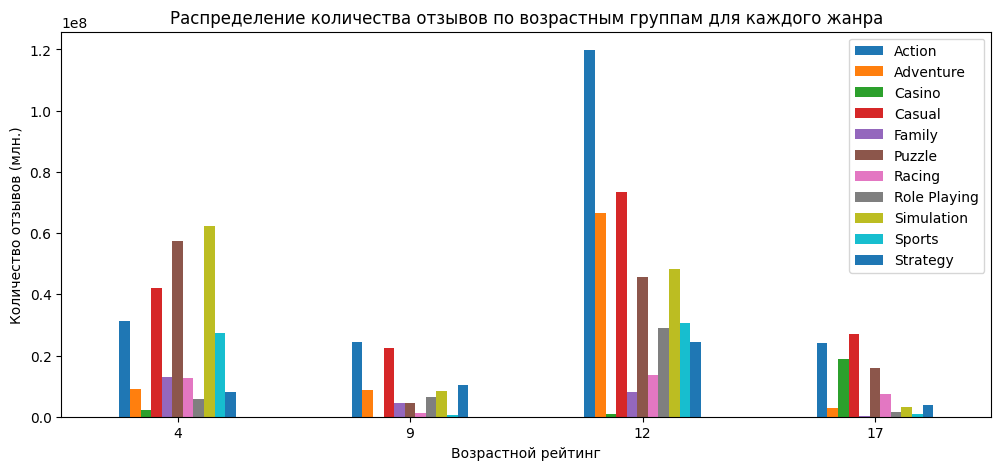

In [24]:
age_group_distribution(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    feature     = 'reviews', 
    title       = 'Распределение количества отзывов по возрастным группам для каждого жанра', 
    xlabel      = 'Возрастной рейтинг', 
    ylabel      = 'Количество отзывов (млн.)'
)

**Из графика видно, что подростки в большей степени склонны к написанию отзывов к играм.**

### Анализ оценок по возрастным группам

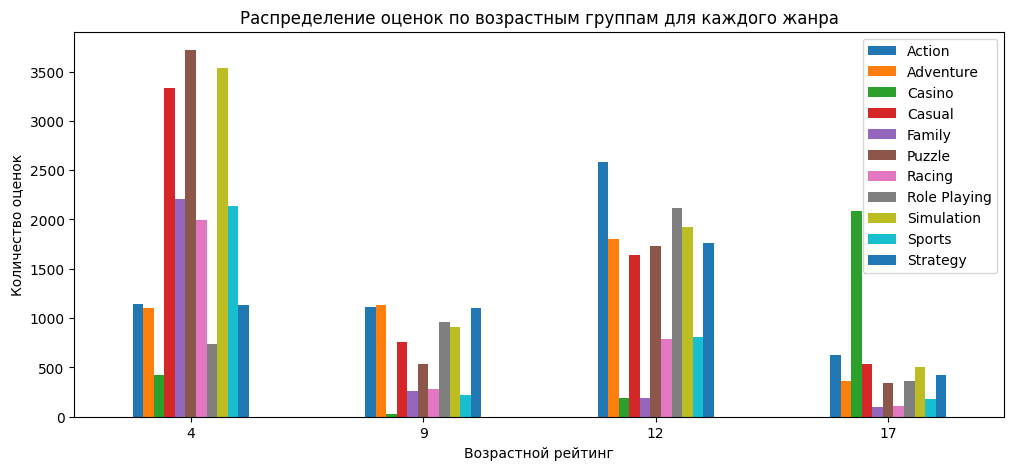

In [25]:
age_group_distribution(
    df          = AppStoreApps, 
    genres_list = genres_list, 
    feature     = 'score', 
    title       = 'Распределение оценок по возрастным группам для каждого жанра', 
    xlabel      = 'Возрастной рейтинг', 
    ylabel      = 'Количество оценок'
)

**Оценки же более склонны оставлять дети в младшем возрасте и чуть в меньшей степени подростки.**

### Популярные жанры в различных коллекциях

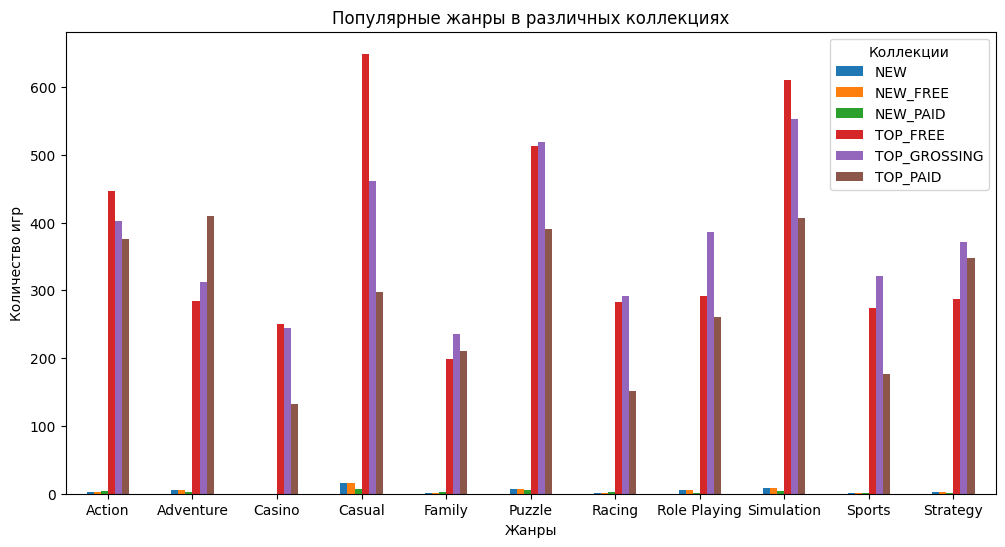

In [26]:
genre_group_distribution(
    df      = AppStoreApps, 
    title   = 'Популярные жанры в различных коллекциях', 
    xlabel  = 'Жанры', 
    ylabel  = 'Количество игр'
)

**Наиболее прибыльными жанрами являются Simulation, Puzzle, Casual**

Исходя из анализа игр, доступных на AppStore, можно сделать вывод о том, что первоначальное предложение заказчика имеет смысл.

Одни из наибольших значений по всем графикам имеют группы **Casual, Puzzle, Simulation**, в виду того что игры этих жанров:
* Легки в освоении
* Не требуют постоянного присутсвия и запоминания сюжета
* Охватывают большую аудиторию людей
* Могут быть запущены на несколько минут
* Быстро скачиваются
* Быстро запускаются
* Не обязательно должны быть платными
* Наиболее популярны среди игроков
* Наиболее прибыльны за счет наличия микротранзакций в игре

## Google

# Проверка статистических гипотез

## Гипотеза 1: Средний рейтинг бесплатных приложений выше, чем платных.

Сравним средние значения двух независимых групп (бесплатные и платные приложения). T-тест поможет определить, есть ли значимые различия между средними значениями рейтингов этих групп.

* **Нулевая гипотеза (H0)**:  
    Средний рейтинг бесплатных приложений равен среднему рейтингу платных приложений.

* **Альтернативная гипотеза (H1)**:  
    Средний рейтинг бесплатных приложений отличается от среднего рейтинга платных приложений.

In [27]:
t_test_free_score(AppStoreApps)

T-statistic: 11.06002763045013 
P-value: 3.156156512637617e-28

Отвергаем нулевую гипотезу. Средний рейтинг бесплатных приложений статистически значимо отличается от среднего рейтинга платных приложений.


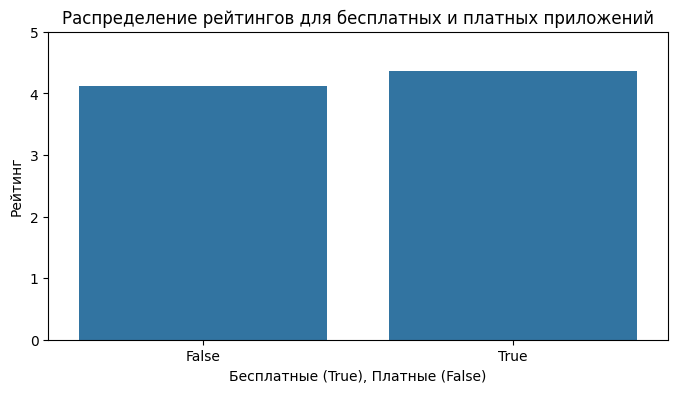

In [28]:
barplot_free_score(
    df      = AppStoreApps, 
    title   = 'Распределение рейтингов для бесплатных и платных приложений', 
    xlabel  = 'Бесплатные (True), Платные (False)', 
    ylabel  = 'Рейтинг'
)

**T-statistic** указывает на степень различия между средними значениями двух групп. Значение 9.4475 является довольно высоким, что говорит о значительном различии между средними рейтингами бесплатных и платных приложений.

**P-value** показывает вероятность того, что наблюдаемые различия могли возникнуть случайно. Значение P-value 5.385700860097099e-21 крайне мало и значительно меньше уровня значимости 0.05, что позволяет отвергнуть нулевую гипотезу с высокой степенью уверенности.

**Вывод:**  
Мы отвергаем нулевую гипотезу H0 и принимаем альтернативную гипотезу H1 . Это означает, что средний рейтинг бесплатных приложений статистически значимо отличается от среднего рейтинга платных приложений.

**Анализ и уточнение выводов:**
1. **Понимание предпочтений пользователей:**  
    **Рейтинг как показатель удовлетворенности:** Средний рейтинг бесплатных игр выше, чем у платных. Это может указывать на то, что пользователи более удовлетворены бесплатными играми по сравнению с платными.  
    **Различия в ожиданиях:** Несмотря на то, что пользователи могут ожидать высокого качества от платных игр, бесплатные приложения получают более высокие оценки. Это может быть связано с тем, что пользователи склонны прощать небольшие недостатки бесплатных игр, так как они не заплатили за них.
2. **Маркетинговые стратегии:**  
    **Монетизация:** Понимание того, что бесплатные приложения имеют более высокие рейтинги, может означать, что привлечение пользователей к бесплатным приложениям с последующей монетизацией через микротранзакции может быть эффективной стратегией.  
    **Продвижение:** Высокий рейтинг бесплатных игр может быть использован в маркетинговых кампаниях для привлечения большего числа пользователей, что затем можно монетизировать через дополнительные платные функции.

**Практическое применение:**
1. **Анализ отзывов:**
    * Необходимо анализировать отзывы, чтобы выявить конкретные элементы, которые делают бесплатные приложения более популярными.
2. **Баланс качества и стоимости:**
    * Учитывая высокий рейтинг бесплатных игр, необходимо поддерживать высокие стандарты качества.
    * Рассмотреть возможность добавления премиальных функций в бесплатные приложения для увеличения монетизации.
**3. Оптимизация пользовательского опыта:**
    * Следует регулярно обновлять и улучшать игру для поддержания высокого уровня удовлетворенности пользователей.

**Заключение:**  
Поскольку средний рейтинг бесплатных приложений выше, чем у платных, следует уделить особое внимание качеству и функциональности игры, чтобы улучшить её восприятие пользователями. Это может привести к увеличению рейтинга и, как следствие, к более успешной монетизации. В то же время, высокий рейтинг бесплатных приложений можно использовать для привлечения пользователей и их последующей конверсии в платные услуги через микротранзакции.  
Что положительно скажется на поступлении денежных средств на нужды приюта.

## Гипотеза 2: Приложения с высоким рейтингом (выше 4.5) чаще входят в коллекцию TOP_GROSSING, чем приложения с более низким рейтингом.

Проверим взаимосвязь между двумя категориальными переменными (наличие в коллекции TOP_GROSSING и высокий рейтинг). Тест хи-квадрат позволит определить, существует ли зависимость между этими переменными.

* **Нулевая гипотеза (H0):**  
    H0: Высокий рейтинг и наличие в коллекции TOP_GROSSING независимы

* **Альтернативная гипотеза (H1):**  
    H1: Высокий рейтинг и наличие в коллекции TOP_GROSSING зависимы

Проверка гипотезы с помощью хи-квадрат теста:

In [29]:
contingency_table = chi2_stat_collection_score(AppStoreApps)

Chi2 Statistic: 37.925341892898174, 
P-value: 7.350423012991126e-10

Отвергаем нулевую гипотезу. Высокий рейтинг и наличие в коллекции TOP_GROSSING зависимы.


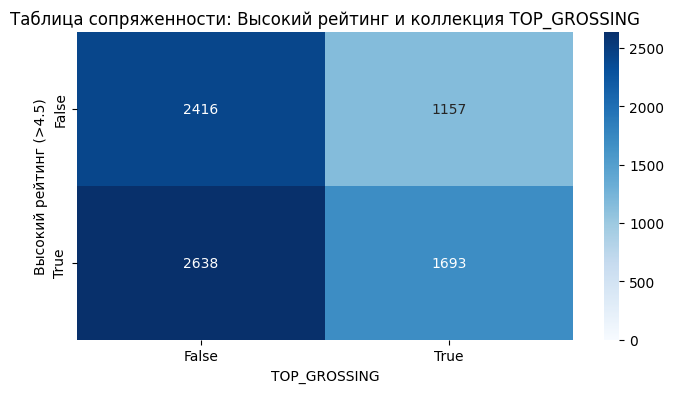

In [30]:
heatmap_collection_score(contingency_table)

**Выводы:**  
**Chi2 Statistic** *указывает на степень отклонения наблюдаемых значений от ожидаемых.* Высокое значение (20.107320380736226) свидетельствует о том, что существует значительная разница между наблюдаемыми и ожидаемыми значениями.  
**P-value** *показывает вероятность того, что наблюдаемые различия могли возникнуть случайно.* Значение P-value 7.321590488850244e-06 значительно меньше уровня значимости 0.05, что позволяет отвергнуть нулевую гипотезу с высокой степенью уверенности.

**Анализ и уточнение выводов:**
1. **Оптимизация рейтинга для повышения дохода:**  
    **Фокус на качество:** Приложения с высокими рейтингами чаще попадают в коллекцию TOP_GROSSING, что указывает на важность поддержания высокого качества и удовлетворенности пользователей.  
    **Стратегии улучшения:** Инвестирование в улучшение пользовательского опыта, функциональности и быстрого реагирования на обратную связь пользователей может привести к повышению рейтинга приложения, что в свою очередь увеличит вероятность попадания в коллекцию TOP_GROSSING и, следовательно, увеличение доходов.

2. **Изучение лидеров:**   
    Анализ конкурентов, которые имеют высокие рейтинги и находятся в коллекции TOP_GROSSING, поможет понять, какие аспекты их приложений делают их успешными и как можно применить эти знания для улучшения игры.

**Заключение:**  
Мы отвергаем нулевую гипотезу H0 и принимаем альтернативную гипотезу H1. Это означает, что высокий рейтинг (> 4.5) и наличие в коллекции TOP_GROSSING статистически значимо связаны. Другими словами, приложения с высокими рейтингами чаще оказываются в коллекции TOP_GROSSING, чем приложения с более низкими рейтингами.